In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
    ExtraTreesRegressor,
    HistGradientBoostingRegressor
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score, KFold

In [2]:
# load the csv file
df = pd.read_csv('./data.csv')
df

,Number,Extractant,Extractant Name,Phenyl Rings,Upper Rim,Lower Rim,Methylene Bridge,Extracted Name,Extractant Conc,Extracted Conc,ion NO3(2-),ions dichloromethane,ions picarate,Chemical Groups,Acid Molarity,Extraction Efficiency
0,1,TOPO,TOPO,NaN,NaN,NaN,NaN,Th(IV),0.000100,0.000100,yes,yes,no,NaN,1M HNO3,0.00
1,2,TOPO,TOPO,NaN,NaN,NaN,NaN,Th(IV),0.000500,0.000100,yes,yes,no,NaN,1M HNO3,0.00
2,3,TOPO,TOPO,NaN,NaN,NaN,NaN,Th(IV),0.001000,0.000100,yes,yes,no,NaN,1M HNO3,0.00
3,4,TOPO,TOPO,NaN,NaN,NaN,NaN,Th(IV),0.005000,0.000100,yes,yes,no,NaN,1M HNO3,1.40
4,5,TOPO,TOPO,NaN,NaN,NaN,NaN,Th(IV),0.010000,0.000100,yes,yes,no,NaN,1M HNO3,10.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,316,2-chloroalkyl,rr,4.0,t-butyl,H,(CH2)6Cl,Ce(III),0.001425,0.000006,yes,yes,no,Na2HPO4,0.1M C6H8O7,87.50
316,317,2-chloroalkyl,rr,4.0,t-butyl,H,(CH2)6Cl,Pr(III),0.001425,0.000006,yes,yes,no,Na2HPO4,0.1M C6H8O7,33.33
317,318,2-chloroalkyl,rr,4.0,t-butyl,H,(CH2)6Cl,Nd(III),0.001425,0.000006,yes,yes,no,Na2HPO4,0.1M C6H8O7,40.00
318,319,2-chloroalkyl,rr,4.0,t-butyl,H,(CH2)6Cl,Sm(III),0.001425,0.000006,yes,yes,no,Na2HPO4,0.1M C6H8O7,NaN


In [ ]:
df_new = df.copy()
df_new = df_new.drop(['Number','Extractant'],axis=1)
df_new = df_new.fillna('none')

categorical_features = ['Upper Rim', 'Lower Rim', 'Methylene Bridge', 'Extracted Name', 'Extractant Name',
						'ion NO3(2-)', 'ions dichloromethane', 'ions picarate','Chemical Groups', 'Acid Molarity']
numerical_features = ['Phenyl Rings', 'Extractant Conc', 'Extracted Conc']

label_encoders = {}

# handle categorical features
for feature in categorical_features:
	le = LabelEncoder()
	if feature not in label_encoders:
		label_encoders[feature] = le
		df_new[feature] = le.fit_transform(df_new[feature])
	else:
		# handle unseen categories during prediction
		new_categories = set(df_new[feature]) - set(label_encoders[feature].classes_)
		if new_categories:
			df_new[feature] = df_new[feature].replace(list(new_categories), 'none')
		df_new[feature] = label_encoders[feature].transform(df_new[feature])

# handle numerical features
for feature in numerical_features:
	# here replace none to 0
	df_new[feature] = df_new[feature].replace('none', 0)
	df_new[feature] = pd.to_numeric(df_new[feature], errors='coerce')

df_new

,Extractant Name,Phenyl Rings,Upper Rim,Lower Rim,Methylene Bridge,Extracted Name,Extractant Conc,Extracted Conc,ion NO3(2-),ions dichloromethane,ions picarate,Chemical Groups,Acid Molarity,Extraction Efficiency
0,1,0.0,7,14,3,20,0.000100,0.000100,1,1,0,7,2,0.0
1,1,0.0,7,14,3,20,0.000500,0.000100,1,1,0,7,2,0.0
2,1,0.0,7,14,3,20,0.001000,0.000100,1,1,0,7,2,0.0
3,1,0.0,7,14,3,20,0.005000,0.000100,1,1,0,7,2,1.4
4,1,0.0,7,14,3,20,0.010000,0.000100,1,1,0,7,2,10.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,37,4.0,9,9,1,2,0.001425,0.000006,1,1,0,1,0,87.5
316,37,4.0,9,9,1,16,0.001425,0.000006,1,1,0,1,0,33.33
317,37,4.0,9,9,1,15,0.001425,0.000006,1,1,0,1,0,40.0
318,37,4.0,9,9,1,18,0.001425,0.000006,1,1,0,1,0,none


In [4]:
# save the preprocessed data
df_new.to_csv('./data_new.csv', index=False)

In [5]:
def prepare_data(df, val_size=0.2, random_state=42):
    """
    Prepare training, validation, and test datasets
    Test set: Rows where Extraction Efficiency is 0
    Validation set: Portion of remaining data
    Training set: Remaining data
    """
    # Split into test and non-test data
    test_mask = df['Extraction Efficiency'] == 'none'
    test_df = df[test_mask].copy()
    train_val_df = df[~test_mask].copy()
    
    # Split remaining data into train and validation
    X_train_val = train_val_df.drop('Extraction Efficiency', axis=1)
    y_train_val = train_val_df['Extraction Efficiency'].astype(float) / 100
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, 
        test_size=val_size, 
        random_state=random_state
    )
    
    # Prepare test set
    X_test = test_df.drop('Extraction Efficiency', axis=1)
    y_test = test_df['Extraction Efficiency']
    
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(df_new)

In [6]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(230, 13) (58, 13) (32, 13)
(230,) (58,) (32,)


In [7]:
print('train x')
print(X_train[:5])
print('train y')
print(y_train[:5])

train x
     Extractant Name  Phenyl Rings  Upper Rim  Lower Rim  Methylene Bridge  \
119               30           4.0          9          8                 3   
79                20           0.0          7         14                 3   
72                18           0.0          7         14                 3   
105               26           4.0          9          7                 3   
25                 4           6.0          9          7                 3   

     Extracted Name  Extractant Conc  Extracted Conc  ion NO3(2-)  \
119              17           0.0025          0.0025            1   
79               20           0.0010          0.0001            1   
72               20           0.0010          0.0001            1   
105              19           0.0025          0.0025            1   
25               20           0.0100          0.0001            1   

     ions dichloromethane  ions picarate  Chemical Groups  Acid Molarity  
119                     0        

In [8]:
def analyze_high_efficiency(df, efficiency_threshold=75):
	"""Analyze patterns in high-efficiency extractions"""
	# Convert efficiency to numeric
	df['Efficiency_Numeric'] = pd.to_numeric(df['Extraction Efficiency'].replace('none', np.nan), errors='coerce')
	
	# Get threshold value
	threshold = np.percentile(df['Efficiency_Numeric'].dropna(), efficiency_threshold)
	high_eff_df = df[df['Efficiency_Numeric'] >= threshold].copy()
	
	print(f"Analysis of high efficiency cases (>{threshold:.1f}%):")
	
	# Analyze common patterns 
	print("Most common extractants in high efficiency cases:")
	print(high_eff_df['Extractant Name'].value_counts().head())

	print("Most common upper rim modifications:")
	print(high_eff_df['Upper Rim'].value_counts().head())

	print("Most common lower rim modifications:")
	print(high_eff_df['Lower Rim'].value_counts().head())

	print("Concentration statistics:")
	print(high_eff_df['Extractant Conc'].describe())

	return high_eff_df

# Run the analysis
high_eff_df = analyze_high_efficiency(df)

Analysis of high efficiency cases (>48.4%):
Most common extractants in high efficiency cases:
Extractant Name
e    6
f    6
p    5
b    4
d    4
Name: count, dtype: int64
Most common upper rim modifications:
Upper Rim
t-butyl    31
H          16
C18H37      4
C10H21      2
C12H25      2
Name: count, dtype: int64
Most common lower rim modifications:
Lower Rim
(CH2)2P(PH)2O         25
NH(CO)(POPh2)         12
(CH2)P(PH)2O          11
(CH2)(CO)(OCH2CH3)     3
OCH3                   3
Name: count, dtype: int64
Concentration statistics:
count    72.000000
mean      0.011607
std       0.030148
min       0.000100
25%       0.001000
50%       0.002500
75%       0.013750
max       0.250000
Name: Extractant Conc, dtype: float64


In [9]:
def try_multiple_models(X_train, X_val, y_train, y_val):
    # Dictionary to store results
    results = {}
    
    # 1. Random Forest
    rf = RandomForestRegressor(random_state=42)
    rf_params = {
        'n_estimators': [100, 150, 200],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 7]
    }
    rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='r2')
    rf_grid.fit(X_train, y_train)
    rf_pred = rf_grid.predict(X_val)
    results['Random Forest'] = {
        'model': rf_grid,
        'r2': r2_score(y_val, rf_pred),
        'mae': mean_absolute_error(y_val, rf_pred),
        'best_params': rf_grid.best_params_
    }

    # 2. Gradient Boosting
    gb = GradientBoostingRegressor(random_state=42)
    gb_params = {
        'n_estimators': [100, 150, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 10, 20]
    }
    gb_grid = GridSearchCV(gb, gb_params, cv=5, scoring='r2')
    gb_grid.fit(X_train, y_train)
    gb_pred = gb_grid.predict(X_val)
    results['Gradient Boost'] = {
        'model': gb_grid,
        'r2': r2_score(y_val, gb_pred),
        'mae': mean_absolute_error(y_val, gb_pred),
        'best_params': gb_grid.best_params_
    }

    # 3. XGBoost
    xgb_model = xgb.XGBRegressor(random_state=42)
    xgb_params = {
        'n_estimators': [100, 150, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 10, 20]
    }
    xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=5, scoring='r2')
    xgb_grid.fit(X_train, y_train)
    xgb_pred = xgb_grid.predict(X_val)
    results['XGBoost'] = {
        'model': xgb_grid,
        'r2': r2_score(y_val, xgb_pred),
        'mae': mean_absolute_error(y_val, xgb_pred),
        'best_params': xgb_grid.best_params_
    }
    
	# 5. Extra Trees
    et_params = {
        'n_estimators': [100, 150, 200],
		'max_depth': [None, 10, 20],
		'min_samples_split': [2, 5, 7]
	}
    et_grid = GridSearchCV(ExtraTreesRegressor(random_state=42), et_params, cv=5, scoring='r2')
    et_grid.fit(X_train, y_train)
    results['Extra Trees'] = {
        'model': et_grid,
        'r2': r2_score(y_val, et_grid.predict(X_val)),
        'mae': mean_absolute_error(y_val, et_grid.predict(X_val)),
        'best_params': et_grid.best_params_
    }
    
	# 6. AdaBoost
    ada_params = {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1],
        'loss': ['linear', 'square', 'exponential']
    }
    ada_grid = GridSearchCV(AdaBoostRegressor(random_state=42), ada_params, cv=5, scoring='r2')
    ada_grid.fit(X_train, y_train)
    results['AdaBoost'] = {
        'model': ada_grid,
        'r2': r2_score(y_val, ada_grid.predict(X_val)),
        'mae': mean_absolute_error(y_val, ada_grid.predict(X_val)),
        'best_params': ada_grid.best_params_
    }
    
	# 7. Hist Gradient Boosting
    hgb_params = {
        'max_iter': [100, 150, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 10, 20]
    }
    hgb_grid = GridSearchCV(HistGradientBoostingRegressor(random_state=42), hgb_params, cv=5, scoring='r2')
    hgb_grid.fit(X_train, y_train)
    results['Histogram GBM'] = {
        'model': hgb_grid,
        'r2': r2_score(y_val, hgb_grid.predict(X_val)),
        'mae': mean_absolute_error(y_val, hgb_grid.predict(X_val)),
        'best_params': hgb_grid.best_params_
    }

	# 10. Decision Tree Regressor
    dt_params = {
		'max_depth': [None, 5, 10, 20],
		'min_samples_split': [2, 5, 7]
	}
    dt_grid = GridSearchCV(DecisionTreeRegressor(random_state=42), dt_params, cv=5, scoring='r2')
    dt_grid.fit(X_train, y_train)
    results['Decision Tree'] = {
		'model': dt_grid,
		'r2': r2_score(y_val, dt_grid.predict(X_val)),
		'mae': mean_absolute_error(y_val, dt_grid.predict(X_val)),
		'best_params': dt_grid.best_params_
	}

    return results

# Function to analyze feature interactions
def analyze_feature_interactions(model, X_train, feature_names):
    # Get feature importance
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    else:
        return None
        
    # Get top 5 important features
    top_features_idx = np.argsort(importances)[-5:]
    top_features = feature_names[top_features_idx]
    
    interactions = []
    for i in range(len(top_features)):
        for j in range(i+1, len(top_features)):
            feat1, feat2 = top_features[i], top_features[j]
            correlation = np.corrcoef(X_train[feat1], X_train[feat2])[0,1]
            interactions.append({
                'features': (feat1, feat2),
                'correlation': correlation
            })
    
    return pd.DataFrame(interactions)

results = try_multiple_models(X_train, X_val, y_train, y_val)
print("\nModel Comparison Results:")
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    print(f"R² Score: {metrics['r2']:.4f}")
    print(f"MAE: {metrics['mae']:.4f}")
    print("Best Parameters:", metrics['best_params'])

c:\Users\shour\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\shour\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(



Model Comparison Results:

Random Forest:
R² Score: 0.5553
MAE: 0.1245
Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}

Gradient Boost:
R² Score: 0.6119
MAE: 0.1061
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}

XGBoost:
R² Score: 0.7084
MAE: 0.0978
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}

Extra Trees:
R² Score: 0.4350
MAE: 0.1408
Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 150}

AdaBoost:
R² Score: 0.3818
MAE: 0.1746
Best Parameters: {'learning_rate': 0.1, 'loss': 'square', 'n_estimators': 50}

Histogram GBM:
R² Score: 0.6006
MAE: 0.1373
Best Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'max_iter': 200}

Decision Tree:
R² Score: 0.3610
MAE: 0.1524
Best Parameters: {'max_depth': 5, 'min_samples_split': 5}



Feature Importance Summary Across Models:
             Feature  Random Forest_importance  Gradient Boost_importance  XGBoost_importance  Extra Trees_importance  AdaBoost_importance  Histogram GBM_importance  Decision Tree_importance
     Extractant Name                  0.660957                   0.798077            0.797839                0.580723             0.272965                  0.640206                  0.723068
        Phenyl Rings                  0.106983                   0.141266            0.124969                0.153834             0.029173                  0.072507                  0.251253
           Upper Rim                  0.106804                   0.051082            0.047340                0.099313             0.029235                  0.067680                  0.000000
           Lower Rim                  0.084160                   0.066595            0.070772                0.104195             0.051350                  0.102916                  0.055267
  

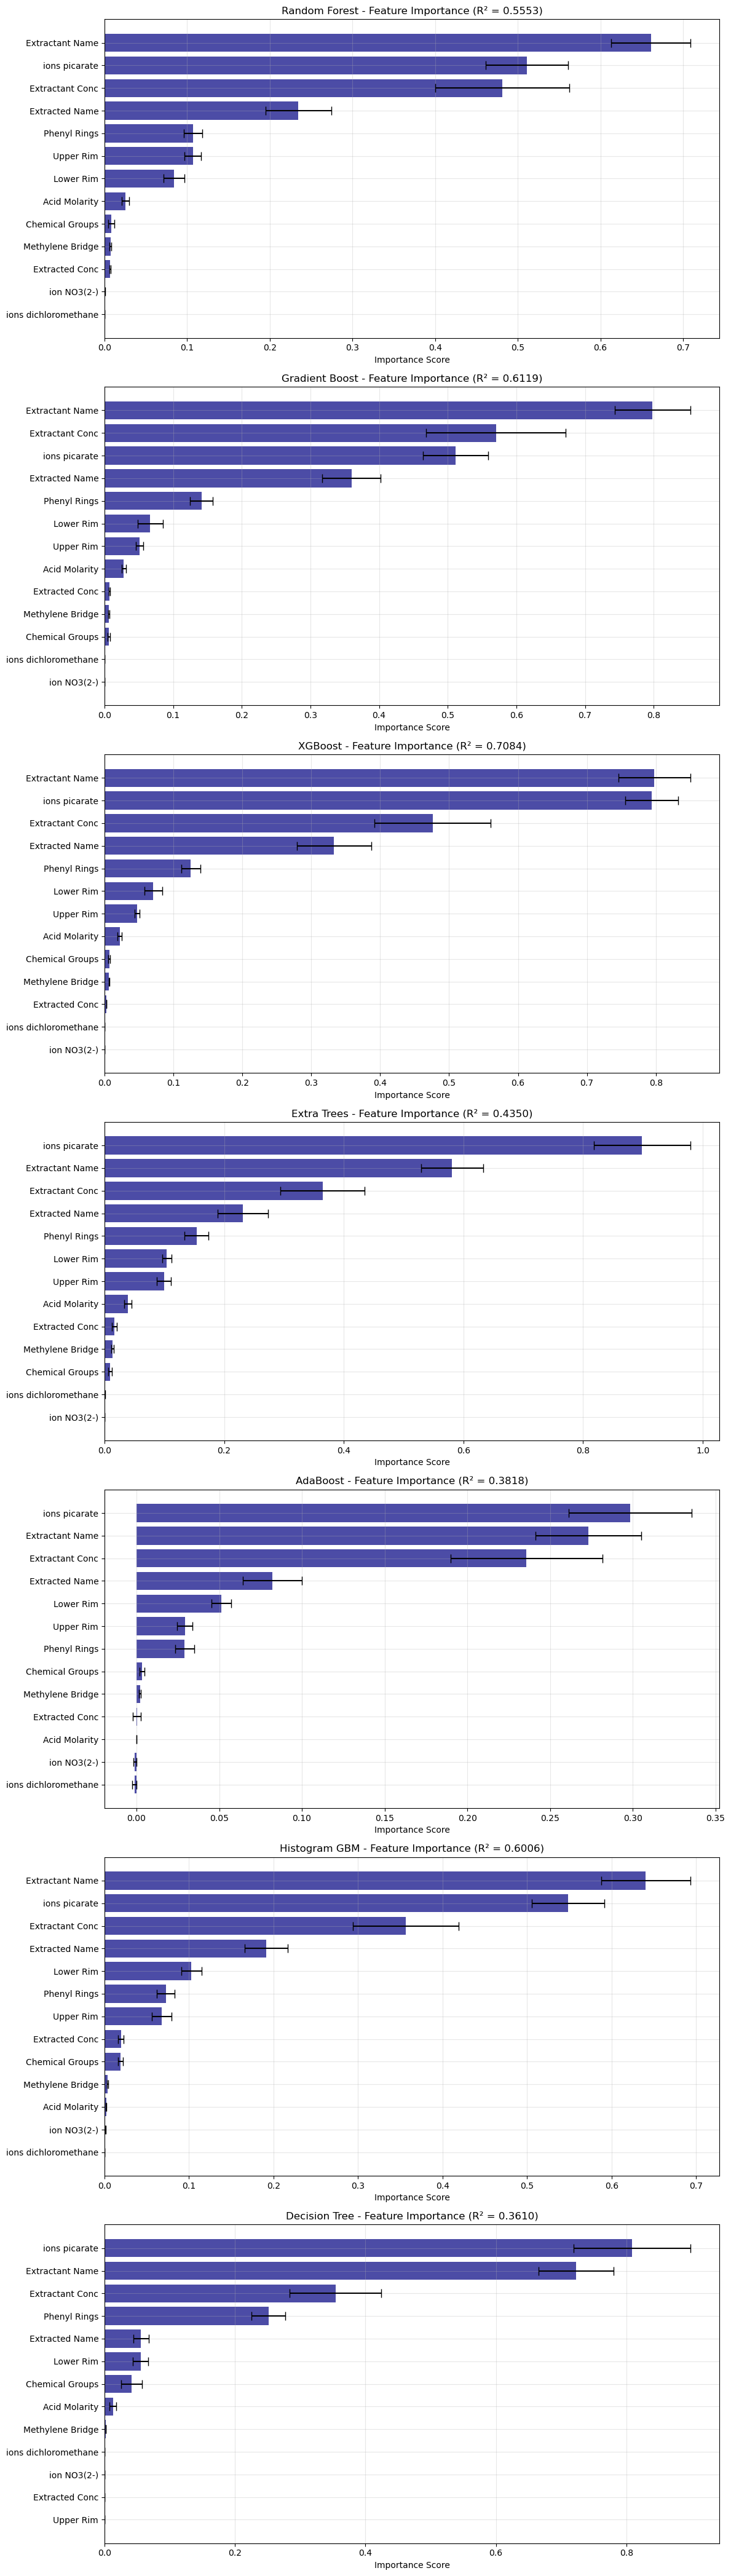

In [10]:
def analyze_all_models_feature_sensitivity(results, X_train, y_train, feature_names):
    """
    Analyze feature sensitivity for all models using permutation importance
    
    Parameters:
    -----------
    results : dict
        Dictionary containing all trained models and their metrics
    X_train : array-like
        Feature matrix
    y_train : array-like
        Target vector
    feature_names : array-like
        List of feature names
    """
    # Dictionary to store importance results for each model
    importance_results = {}
    
    # Calculate permutation importance for each model
    for model_name, model_dict in results.items():
        model = model_dict['model'].best_estimator_
        
        # Calculate permutation importance
        result = permutation_importance(
            model, X_train, y_train,
            n_repeats=10,
            random_state=42
        )
        
        # Store results
        importance_results[model_name] = {
            'importance': result.importances_mean,
            'std': result.importances_std
        }
    
    # Create a combined plot
    n_features = len(feature_names)
    n_models = len(results)
    
    fig, axes = plt.subplots(n_models, 1, figsize=(12, 6*n_models))
    
    # Plot for each model
    for idx, (model_name, importance_dict) in enumerate(importance_results.items()):
        ax = axes[idx] if n_models > 1 else axes
        
        # Sort features by importance
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importance_dict['importance'],
            'std': importance_dict['std']
        }).sort_values('importance', ascending=True)  # Ascending for horizontal bar plot
        
        # Create horizontal bar plot
        ax.barh(range(n_features), importance_df['importance'],
                xerr=importance_df['std'], 
                capsize=5,
                alpha=0.7,
                color='navy')
        
        ax.set_yticks(range(n_features))
        ax.set_yticklabels(importance_df['feature'])
        ax.set_xlabel('Importance Score')
        ax.set_title(f'{model_name} - Feature Importance (R² = {results[model_name]["r2"]:.4f})')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Create a summary DataFrame
    summary_data = []
    for feature in feature_names:
        feature_data = {'Feature': feature}
        for model_name in results.keys():
            importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': importance_results[model_name]['importance']
            })
            feature_data[f'{model_name}_importance'] = importance_df[
                importance_df['feature'] == feature
            ]['importance'].values[0]
        summary_data.append(feature_data)
    
    summary_df = pd.DataFrame(summary_data)
    
    # Print summary table
    print("\nFeature Importance Summary Across Models:")
    print(summary_df.to_string(index=False))
    
    return summary_df, importance_results

# Run the analysis for all models
summary_df, importance_results = analyze_all_models_feature_sensitivity(
    results, X_train, y_train, X_train.columns
)

# Print the top 5 most important features for each model
print("\nTop 5 Most Important Features by Model:")
for model_name in results.keys():
    importance_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': importance_results[model_name]['importance']
    }).sort_values('importance', ascending=False)
    
    print(f"\n{model_name}:")
    print(importance_df.head().to_string(index=False))

In [11]:
# Function to print detailed results
def print_model_comparison(results):
    print("\nModel Comparison Results:")
    # Create a DataFrame for easy comparison
    comparison_df = pd.DataFrame({
        'Model': [],
        'R² Score': [],
        'MAE': [],
        'Best Parameters': []
    })
    
    for model_name, metrics in results.items():
        new_row = pd.DataFrame({
            'Model': [model_name],
            'R² Score': [metrics['r2']],
            'MAE': [metrics['mae']],
            'Best Parameters': [str(metrics['best_params'])]
        })
        comparison_df = pd.concat([comparison_df, new_row], ignore_index=True)
    
    # Sort by R² score descending
    comparison_df = comparison_df.sort_values('R² Score', ascending=False)
    
    # Print formatted results
    print("\nModel Performance Summary:")
    print(comparison_df.to_string(index=False))
    
    # Print top 3 models
    print("\nTop 3 Performing Models:")
    print(comparison_df.head(3).to_string(index=False))
    
print_model_comparison(results)


Model Comparison Results:

Model Performance Summary:
         Model  R² Score      MAE                                                  Best Parameters
       XGBoost  0.708406 0.097847      {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Gradient Boost  0.611945 0.106060      {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}
 Histogram GBM  0.600565 0.137328         {'learning_rate': 0.1, 'max_depth': 10, 'max_iter': 200}
 Random Forest  0.555334 0.124471   {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
   Extra Trees  0.435012 0.140766 {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 150}
      AdaBoost  0.381776 0.174598     {'learning_rate': 0.1, 'loss': 'square', 'n_estimators': 50}
 Decision Tree  0.360963 0.152415                         {'max_depth': 5, 'min_samples_split': 5}

Top 3 Performing Models:
         Model  R² Score      MAE                                             Best Parameters
       XGBoost  0.708406 0.097847

In [12]:
def perform_cv_and_predict(results, X_train, X_val, X_test, y_train, y_val, n_folds=5):
    """
    Perform cross-validation with the best parameters and generate predictions for test set
    First merges training and validation sets for cross-validation
    
    Parameters:
    -----------
    results: dict
        Dictionary containing the GridSearchCV results for each model
    X_train, X_val, X_test: array-like
        Training, validation and test features
    y_train, y_val: array-like
        Training and validation targets
    n_folds: int
        Number of folds for cross-validation
    """
    # Merge training and validation sets
    X_train_full = pd.concat([X_train, X_val])
    y_train_full = pd.concat([y_train, y_val])
    
    cv_results = {}
    test_predictions = {}
    
    # Create KFold object
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    for model_name, model_dict in results.items():
        print(f"\nProcessing {model_name}...")
        
        # Get the best model with its parameters
        best_model = model_dict['model'].best_estimator_
        
        # Perform cross-validation
        cv_r2_scores = cross_val_score(best_model, X_train_full, y_train_full, 
                                     cv=kf, scoring='r2')
        cv_mae_scores = cross_val_score(best_model, X_train_full, y_train_full, 
                                      cv=kf, scoring='neg_mean_absolute_error')
        cv_mae_scores = -cv_mae_scores  # Convert back to positive MAE
        
        # Store CV results
        cv_results[model_name] = {
            'cv_r2_mean': cv_r2_scores.mean(),
            'cv_r2_std': cv_r2_scores.std(),
            'cv_mae_mean': cv_mae_scores.mean(),
            'cv_mae_std': cv_mae_scores.std(),
            'cv_r2_scores': cv_r2_scores,
            'cv_mae_scores': cv_mae_scores
        }
        
        # Generate predictions for test set
        print(f"Fitting {model_name} on full training data...")
        best_model.fit(X_train_full, y_train_full)  # Refit on full training set
        test_predictions[model_name] = {
            'predictions': best_model.predict(X_test) * 100  # Convert back to percentage
        }
    
    # Create summary DataFrame for CV results
    cv_summary = pd.DataFrame({
        'Model': [],
        'CV R² (mean ± std)': [],
        'CV MAE (mean ± std)': [],
        'Best Parameters': []
    })
    
    for model_name in results.keys():
        new_row = pd.DataFrame({
            'Model': [model_name],
            'CV R² (mean ± std)': [f"{cv_results[model_name]['cv_r2_mean']:.4f} ± {cv_results[model_name]['cv_r2_std']:.4f}"],
            'CV MAE (mean ± std)': [f"{cv_results[model_name]['cv_mae_mean']:.4f} ± {cv_results[model_name]['cv_mae_std']:.4f}"],
            'Best Parameters': [str(results[model_name]['model'].best_params_)]
        })
        cv_summary = pd.concat([cv_summary, new_row], ignore_index=True)
    
    # Sort by CV R² mean
    cv_summary = cv_summary.sort_values(by='CV R² (mean ± std)', ascending=False)
    
    # Print cross-validation results
    print("\nCross-Validation Results Summary:")
    print("=================================")
    print(cv_summary.to_string(index=False))
    
    # Print detailed fold-by-fold results for top 3 models
    print("\nDetailed Cross-Validation Results for Top 3 Models:")
    print("=================================================")
    top_3_models = cv_summary['Model'].head(3).tolist()
    
    for model_name in top_3_models:
        print(f"\n{model_name}:")
        print(f"R² scores per fold: {cv_results[model_name]['cv_r2_scores']}")
        print(f"Mean R²: {cv_results[model_name]['cv_r2_mean']:.4f}")
        print(f"R² Standard Deviation: {cv_results[model_name]['cv_r2_std']:.4f}")
        print(f"MAE scores per fold: {cv_results[model_name]['cv_mae_scores']}")
        print(f"Mean MAE: {cv_results[model_name]['cv_mae_mean']:.4f}")
        print(f"MAE Standard Deviation: {cv_results[model_name]['cv_mae_std']:.4f}")
    
    # Create DataFrame with predictions from all models
    predictions_df = pd.DataFrame()
    for model_name in results.keys():
        predictions_df[f'{model_name}_predictions'] = test_predictions[model_name]['predictions']
    
    # Add ensemble prediction (average of all models)
    predictions_df['Ensemble_Mean'] = predictions_df.mean(axis=1)
    
    print("\nTest Set Predictions Summary:")
    print("============================")
    print("\nFirst few predictions from each model:")
    print(predictions_df.head().to_string())
    
    print("\nSummary statistics of predictions:")
    print(predictions_df.describe().to_string())
    
    return cv_results, predictions_df, cv_summary

In [13]:
# Run the analysis with merged training and validation sets
print("Starting cross-validation and prediction analysis...")
cv_results, predictions_df, cv_summary = perform_cv_and_predict(
    results, X_train, X_val, X_test, y_train, y_val
)

Starting cross-validation and prediction analysis...

Processing Random Forest...
Fitting Random Forest on full training data...

Processing Gradient Boost...
Fitting Gradient Boost on full training data...

Processing XGBoost...
Fitting XGBoost on full training data...

Processing Extra Trees...
Fitting Extra Trees on full training data...

Processing AdaBoost...
Fitting AdaBoost on full training data...

Processing Histogram GBM...
Fitting Histogram GBM on full training data...

Processing Decision Tree...
Fitting Decision Tree on full training data...

Cross-Validation Results Summary:
         Model CV R² (mean ± std) CV MAE (mean ± std)                                                  Best Parameters
       XGBoost    0.7434 ± 0.1057     0.0964 ± 0.0237      {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Gradient Boost    0.7300 ± 0.1000     0.0976 ± 0.0187      {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}
 Random Forest    0.6888 ± 0.0695     0.1197 ± 

In [15]:
# Save predictions to CSV
predictions_df.to_csv('model_predictions.csv', index=False)
print("\nPredictions have been saved to 'model_predictions.csv'")

# Print the range of predictions
print(f"Range: {predictions_df}")

# Print some additional analysis
print("\nPrediction Range Analysis:")
print("=========================")
for column in predictions_df.columns:
    print(f"\n{column}:")
    print(f"Min: {predictions_df[column].min():.2f}%")
    print(f"Max: {predictions_df[column].max():.2f}%")
    print(f"Mean: {predictions_df[column].mean():.2f}%")
    print(f"Median: {predictions_df[column].median():.2f}%")


Predictions have been saved to 'model_predictions.csv'
Range:     Random Forest_predictions  Gradient Boost_predictions  \
0                   21.642673                    0.948716   
1                   95.044762                   96.190999   
2                   92.601845                   95.873548   
3                   57.480305                   63.313795   
4                   92.047595                  113.336135   
5                   95.750929                  120.535818   
6                   91.796179                  114.360542   
7                   31.546602                    9.363085   
8                   50.212891                   38.177019   
9                   81.467254                   68.649149   
10                  77.120762                   83.529799   
11                  45.972935                   51.993918   
12                  70.964491                   84.843274   
13                  92.640254                  105.553967   
14                  94